In [1]:
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/sentiment-analysis-lstm/'

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
project_path = '/content/drive/MyDrive/sentiment-analysis-lstm/'

In [9]:
#load dataset
df = pd.read_csv(project_path + 'data/IMDB-Dataset.csv')
print(df.columns)
print(df['label'].unique())

Index(['text', 'label'], dtype='object')
[0 1]


In [10]:
df = df[['text', 'label']]
df['label'] = df['label'].astype(int)
print(df.shape)
df.head()

(5000, 2)


,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [12]:
#Text Cleaning
import re

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^a-zA-Z ]', '', text)  # keep only letters
    text = text.lower()
    return text

df['cleaned'] = df['text'].apply(clean_text)
df[['cleaned', 'label']].head()

,cleaned,label
0,i always wrote this series off as being a comp...,0
1,st watched out of dirsteve purcell typical ...,0
2,this movie was so poorly written and directed ...,0
3,the most interesting thing about miryang secre...,1
4,when i first read about berlin am meer i didnt...,0


In [14]:
#Tokenization & Padding
max_words = 10000
maxlen = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned'])

sequences = tokenizer.texts_to_sequences(df['cleaned'])
X = pad_sequences(sequences, maxlen=maxlen)
y = df['label'].values

In [15]:
#load GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove

#embedding vectors
embedding_index = {}
with open('glove/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

#Build embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

--2025-07-13 18:49:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-13 18:49:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-13 18:49:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [25]:
#LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    X, y,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 380ms/step - accuracy: 0.5304 - loss: 0.6930 - val_accuracy: 0.6880 - val_loss: 0.6375
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - accuracy: 0.7300 - loss: 0.5555 - val_accuracy: 0.7440 - val_loss: 0.5239
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 387ms/step - accuracy: 0.7982 - loss: 0.4607 - val_accuracy: 0.7960 - val_loss: 0.4449
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 364ms/step - accuracy: 0.8436 - loss: 0.3811 - val_accuracy: 0.8260 - val_loss: 0.3918
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 418ms/step - accuracy: 0.9035 - loss: 0.2737 - val_accuracy: 0.8210 - val_loss: 0.4125
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 364ms/step - accuracy: 0.9115 - loss: 0.2440 - val_accuracy: 0.8440 - val_loss: 0.4031


In [27]:
#save model to google drive
model.save(project_path + 'model/sentiment_model_glove.h5')

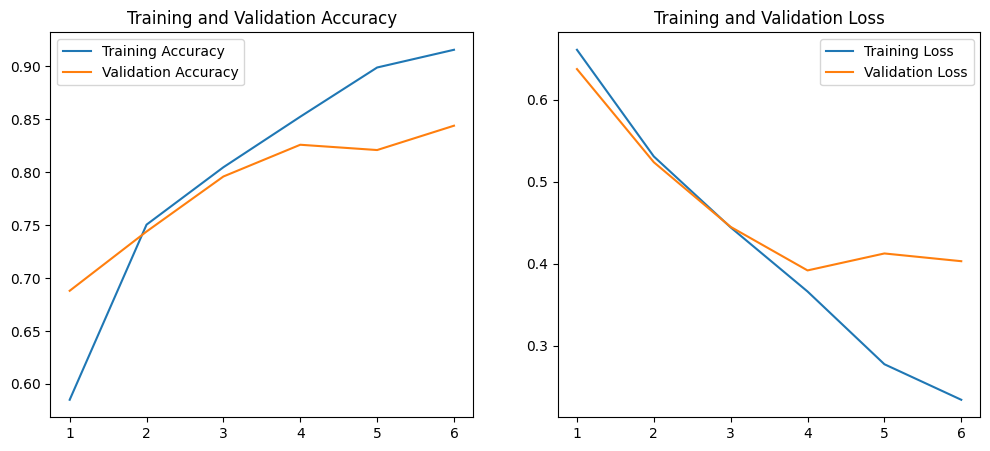

In [28]:
#plot Accuracy & Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [29]:
import pickle

with open(project_path + 'model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
